In [ ]:
# Vous pourriez avoir besoin d'exécuter le code ci dessous en commentaire
# si une erreur survient lors de l'exécution du notebook
#!pip install numpy==1.19.5

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np
import pandas as pd
import string, os 

In [2]:
all_reviews = []
data = pd.read_csv('english.csv')
all_reviews.extend(list(data.text.values))

In [3]:
len(all_reviews)

2298

In [4]:
all_reviews = all_reviews[:1000]

In [5]:
len(all_reviews)

1000

In [6]:
def clean_text(txt):
    txt = "".join(v for v in txt if v not in string.punctuation).lower()
    txt = txt.encode("utf8").decode("ascii",'ignore')
    return txt 

corpus = [clean_text(x) for x in all_reviews]
corpus[:10]

['a bird in the hand is worth two in the bush',
 'a bunch of fives',
 'a chain is only as strong as its weakest link',
 'a change is as good as a rest',
 'a countenance more in sorrow than in anger',
 'a daniel come to judgement',
 'a diamond in the rough',
 'a diamond is forever',
 'a different kettle of fish',
 'a dish fit for the gods']

In [7]:
tokenizer = Tokenizer()



tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1


In [8]:
input_seq = []
for line in all_reviews:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_seq = token_list[:i+1]
        input_seq.append(n_gram_seq)

In [9]:
def gen_pad_seq(input_seq):
    max_sequence_len = max([len(x) for x in input_seq])
    input_seq = np.array(pad_sequences(input_seq, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_seq[:,:-1],input_seq[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = gen_pad_seq(input_seq)

In [10]:
max_sequence_len

14

In [11]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def perplexity(y_true, y_pred):
    cross_entropy = K.categorical_crossentropy(y_true, y_pred)
    perplexity = K.pow(2.0, cross_entropy)
    return perplexity

In [12]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add((LSTM(150, activation='relu', return_sequences = True)))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_m, perplexity])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 13, 100)           155300    
_________________________________________________________________
lstm (LSTM)                  (None, 13, 150)           150600    
_________________________________________________________________
dropout (Dropout)            (None, 13, 150)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               100400    
_________________________________________________________________
dense (Dense)                (None, 776)               78376     
_________________________________________________________________
dropout_1 (Dropout)          (None, 776)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1553)              1

In [13]:
batch_size = 32 # minibatch 
num_epochs = 300 # nombre d'epochs


#fit the model
history = model.fit(predictors, label,
                 batch_size=batch_size,
                 shuffle=True,
                 epochs=num_epochs,
                 validation_split=0.2)



Epoch 1/300
73/73 [==============================] - 9s 75ms/step - loss: 7.9652 - accuracy: 0.0671 - f1_m: 0.0000e+00 - perplexity: 163.3758 - val_loss: 6.6768 - val_accuracy: 0.0723 - val_f1_m: 0.0000e+00 - val_perplexity: 165.0733
Epoch 2/300
73/73 [==============================] - 4s 62ms/step - loss: 6.1529 - accuracy: 0.0855 - f1_m: 0.0000e+00 - perplexity: 128.5332 - val_loss: 6.6809 - val_accuracy: 0.0723 - val_f1_m: 0.0000e+00 - val_perplexity: 277.6906
Epoch 3/300
73/73 [==============================] - 4s 61ms/step - loss: 5.9668 - accuracy: 0.0668 - f1_m: 0.0000e+00 - perplexity: 115.9521 - val_loss: 6.7032 - val_accuracy: 0.0723 - val_f1_m: 0.0000e+00 - val_perplexity: 506.2223
Epoch 4/300
73/73 [==============================] - 5s 62ms/step - loss: 5.7374 - accuracy: 0.0792 - f1_m: 0.0000e+00 - perplexity: 108.3655 - val_loss: 6.8755 - val_accuracy: 0.0723 - val_f1_m: 0.0000e+00 - val_perplexity: 1658.3820
Epoch 5/300
73/73 [==============================] - 4s 61ms/st

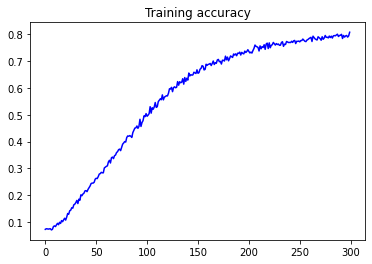

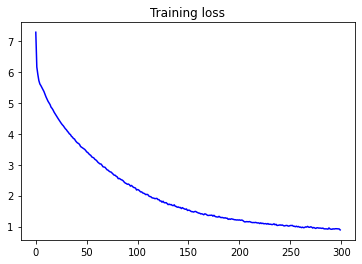

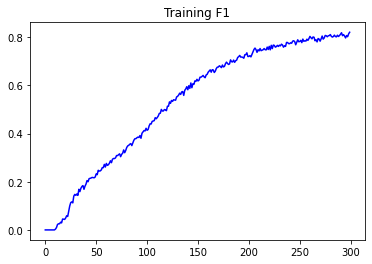

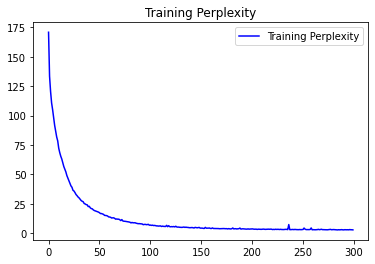

In [14]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
f1 = history.history["f1_m"]
perplex = history.history["perplexity"]
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.figure()
plt.plot(epochs, f1, 'b', label='Training F1')
plt.title('Training F1')
plt.figure()
plt.plot(epochs, perplex, 'b', label='Training Perplexity')
plt.title('Training Perplexity')
plt.legend()
plt.show()

In [15]:
def gen_proverbs(seed, n_words):

  for _ in range(n_words):
    token_list = tokenizer.texts_to_sequences([seed])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output = ""
    for word, index in tokenizer.word_index.items():
      if index == predicted:
        output = word
        break
    seed += " " + output
  return seed
  



In [55]:
gen_proverbs("", 10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


' breast make a bee for pie the bell miles away'